# PyTorch Ligthing Basics

Адаптация статьи [Pytorch lightning. Simple is better](https://habr.com/ru/articles/586212/) со сравнением PyTorch и PyTorch Lightning для создания классификатора.

In [1]:
import os
import sys
import multiprocessing
import importlib
from tqdm.notebook import tqdm

libraries_aliases = {'torch': None,
                      'torchvision': None,
                      'tensorboardX': None,
                      'lightning': None,
                      'matplotlib.pyplot': 'plt'}


def add_library_to_globals(library, alias):
    module = importlib.import_module(library)
    if alias:
        globals()[alias] = module
    else:
        globals()[library.split('.')[-1]] = module


for library, alias in libraries_aliases.items():
    try:
        add_library_to_globals(library, alias)
    except ImportError:
        # если не смогли импортировать, устанавливаем
        !{sys.executable} -m pip install {library} --quiet
        add_library_to_globals(library, alias)


from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from lightning import Trainer

!pip install jupyter_contrib_nbextensions --quiet
!jupyter nbextension install --py widgetsnbextension --user
!jupyter nbextension enable widgetsnbextension --user --py

Installing /opt/homebrew/lib/python3.11/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /Users/leo/Library/Jupyter/nbextensions/jupyter-js-widgets/extension.js.LICENSE.txt
Up to date: /Users/leo/Library/Jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /Users/leo/Library/Jupyter/nbextensions/jupyter-js-widgets/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --user --py
    
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Настраиваем количество эпох обучения и SEED для сопоставимости результатов.

In [3]:
EPOCHS = 10
SEED = 42

torch.random.manual_seed(42)
lightning.seed_everything(42)

Global seed set to 42


42

In [4]:
transforms_set=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

In [5]:
# Загрузка тренировочного датасета.
train_data = MNIST(root="data",
                   train=True,
                   download=True,
                   transform=transforms_set)

# Загрузка тестового датасета
test_data = MNIST(root="data",
                  train=False,
                  download=True,
                  transform=transforms_set)

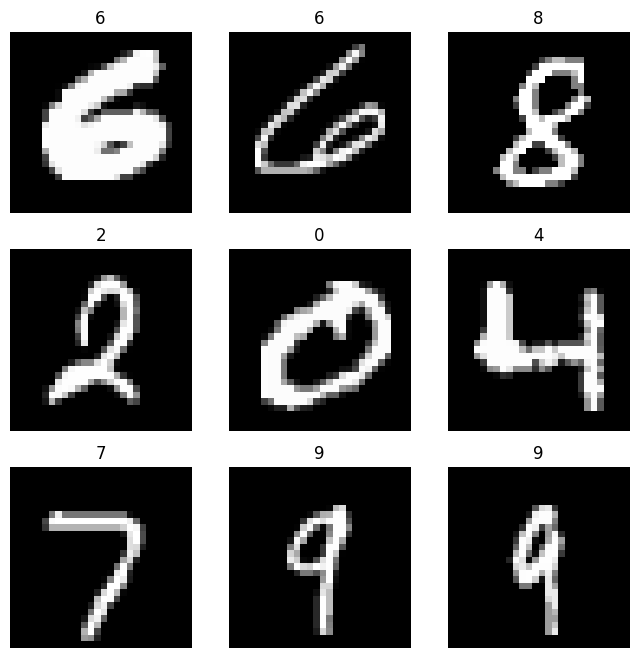

In [6]:
labels_dict = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_index]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show() 

In [7]:
num_workers = multiprocessing.cpu_count()
train_data_loader = DataLoader(train_data, batch_size=16, num_workers=num_workers)
test_data_loader = DataLoader(test_data, batch_size=16, num_workers=num_workers)

# Реализация на PyTorch

In [ ]:
class Pytorch_MNIST_Classifier(nn.Module):
    def __init__(self):
        super(Pytorch_MNIST_Classifier, self).__init__()
        # картинки датасета MNIST  c размером (1, 28, 28) (количество каналов, ширина, высота) 
        self.layer_1 = torch.nn.Linear(28 * 28, 64)
        self.layer_2 = torch.nn.Linear(64, 32)
        self.layer_3 = torch.nn.Linear(32, 10)
 
    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # слой 1
        x = self.layer_1(x)
        x = torch.relu(x)

        # слой 2
        x = self.layer_2(x)
        x = torch.relu(x)

        # слой 3
        x = self.layer_3(x)

        # вероятность принадлежности к классу
        x = torch.log_softmax(x, dim=1)

        return x

In [ ]:
Pytorch_MNIST_model = Pytorch_MNIST_Classifier()
# Оптимизатор и функция потерь
optimizer = torch.optim.AdamW(Pytorch_MNIST_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Запускается тренировочный цикл
for epoch in range(EPOCHS):
    size = len(train_data_loader.dataset)
    
    # Загрузчик данных передает данные и их классы
    for batch_num, (X, y) in enumerate(train_data_loader):

        # Нейросеть обрабатывает данные и возвращает предсказания
        pred = Pytorch_MNIST_model(X)
        # Вычисляется функция потерь
        loss = loss_func(pred, y)

        # Обратным распространением обновляются веса в нейронах
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Для наглядности печатаются значения функции потерь
        if batch_num % 1000 == 0:
            loss, current = loss.item(), batch_num * len(X)
            print(f"[{current:>5d}/{size:>5d}] loss: {loss:>7f}")

In [ ]:
 %%time
size = len(test_data_loader.dataset)
batches = len(test_data_loader)
test_loss, correct = 0, 0

# Модель переключается в режим оценки
Pytorch_MNIST_model.eval()

# Отключение вычисления градиентов
with torch.no_grad():
    # Запускается цикл тестирования
    for X, y in test_data_loader:
        # Нейросеть обрабатывает данные и возвращает предсказания
        pred = Pytorch_MNIST_model(X)
        # Складываются корректные предсказания
        test_loss += loss_func(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= batches
correct /= size

# Вычисляется метрика качества
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Реализация на PyTorch Lightning

In [8]:
class Pytorch_Lightning_MNIST_Classifier(lightning.LightningModule):
    def __init__(self):
        super().__init__()
        # Задается архитектура нейросети
        self.layers = nn.Sequential(
          nn.Linear(28 * 28 * 1, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 10)
        )
        # Объявляется функция потерь
        self.loss_func = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.layers(x)

    # Настраиваются параметры обучения
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        pred = self.layers(x)
        loss = self.loss_func(pred, y)
        self.log('train_loss', loss)
        return loss

    # Настраиваются параметры тестирования
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        pred = self.layers(x)
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    # Конфигурируется оптимизатор
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
from lightning.pytorch.callbacks import TQDMProgressBar

# Инициализация модели и функции Trainer

Pytorch_lightning_MNIST_model = Pytorch_Lightning_MNIST_Classifier()
trainer = lightning.Trainer(max_epochs=EPOCHS, callbacks=[TQDMProgressBar()])

# Обучение модели
trainer.fit(Pytorch_lightning_MNIST_model, train_data_loader)

# Тестирование модели
trainer.test(Pytorch_lightning_MNIST_model, test_data_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | layers    | Sequential       | 52.6 K
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
52.6 K    Trainable params
0         Non-trainable params
52.6 K    Total params
0.211     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]